In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import pickle
import h5py
import glob
import sys
import os

plt.rc('font', size=14)

In [7]:
# Load the MCMC samples
with h5py.File('samples_mcmc.h5', 'r') as fid:
    mcmc_samples = fid['samples'][()]
    n_samples = mcmc_samples.shape[0]

# Load normalizing flow (Real-NVP) samples
with h5py.File('samples_nflow.h5', 'r') as fid:
    nflow_samples = fid['samples'][()]
    
# Load MVN variational inference mean and covariance; generate samples
with open('params_cov.pkl', 'rb') as fid:
    _, _, mu, cov = [pickle.load(fid) for _ in range(4)]
cov_samples = stats.multivariate_normal.rvs(mu, cov, size=n_samples)

# Load optimization mean and covariance (inverse of Hessian of objective function)
# These results are equivalent to the Laplace approximation
with open('params_optimization.pkl', 'rb') as fid:
    mu, cov = [pickle.load(fid) for _ in range(2)]
opt_samples = stats.multivariate_normal.rvs(mu, cov, size=n_samples)

# Subsample all
mcmc_samples, nflow_samples, cov_samples, opt_samples = [
    arr[::2, :] for arr in
    (mcmc_samples, nflow_samples, cov_samples, opt_samples)
]
n_samples = mcmc_samples.shape[0]

methods = ['MCMC'] * n_samples + ['Cov'] * n_samples + ['NF'] * n_samples + ['Opt'] * n_samples

In [8]:
# Create data frame to contain samples of the different methods
df_data = {}
for i in range(mcmc_samples.shape[1]):
    df_data['x%d' % i] = np.hstack((mcmc_samples[:, i],
                                    cov_samples[:, i],
                                    nflow_samples[:, i],
                                    opt_samples[:,i]))
df_data['Method'] = methods
df = pd.DataFrame(df_data)

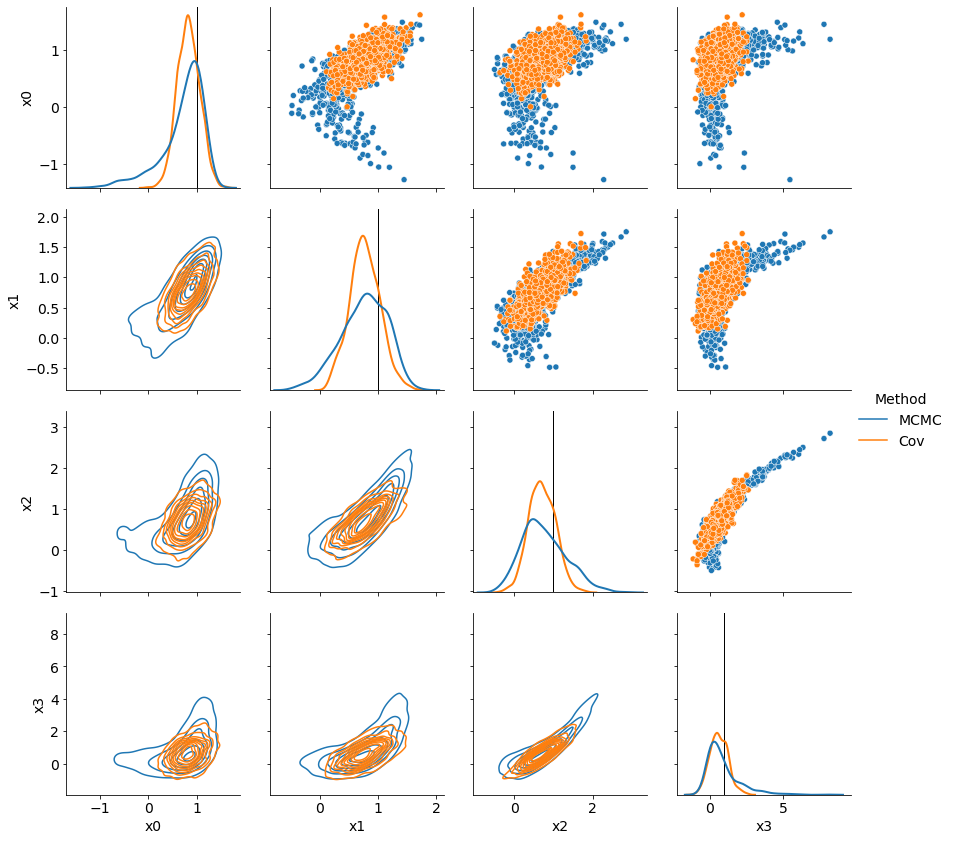

In [9]:
# First compare MCMC with MVN variational inference
sub_df = df.loc[df['Method'].isin(['MCMC', 'Cov'])]

g = sns.PairGrid(sub_df, hue='Method', height=3)
g.map_diag(sns.kdeplot, lw=2, legend=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.add_legend()

# Plot true Rosenbrock minimum values
for i in range(N_dim):
    ax = g.axes[i, i]
    ax.axvline(1, color='k', lw=1)

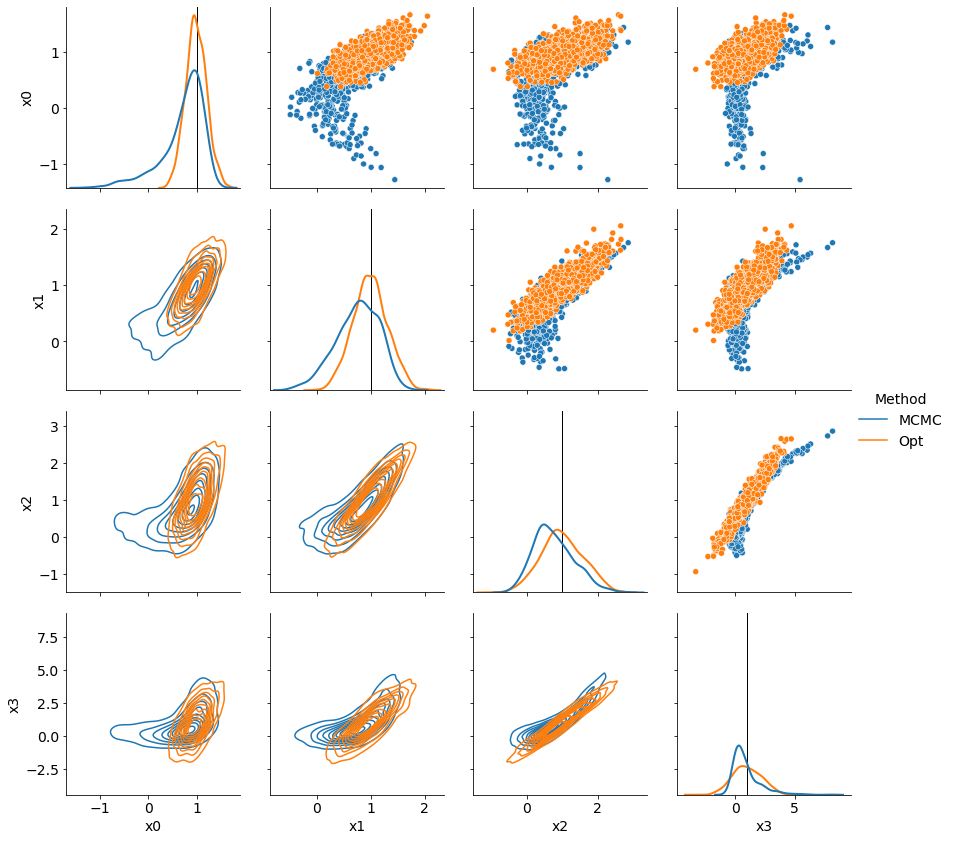

In [10]:
# Now compare MCMC with optimization based samples (MAP and inverse Hessian)
sub_df = df.loc[df['Method'].isin(['MCMC', 'Opt'])]

g = sns.PairGrid(sub_df, hue='Method', height=3)
g.map_diag(sns.kdeplot, lw=2, legend=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.add_legend()

for i in range(N_dim):
    ax = g.axes[i, i]
    ax.axvline(1, color='k', lw=1)

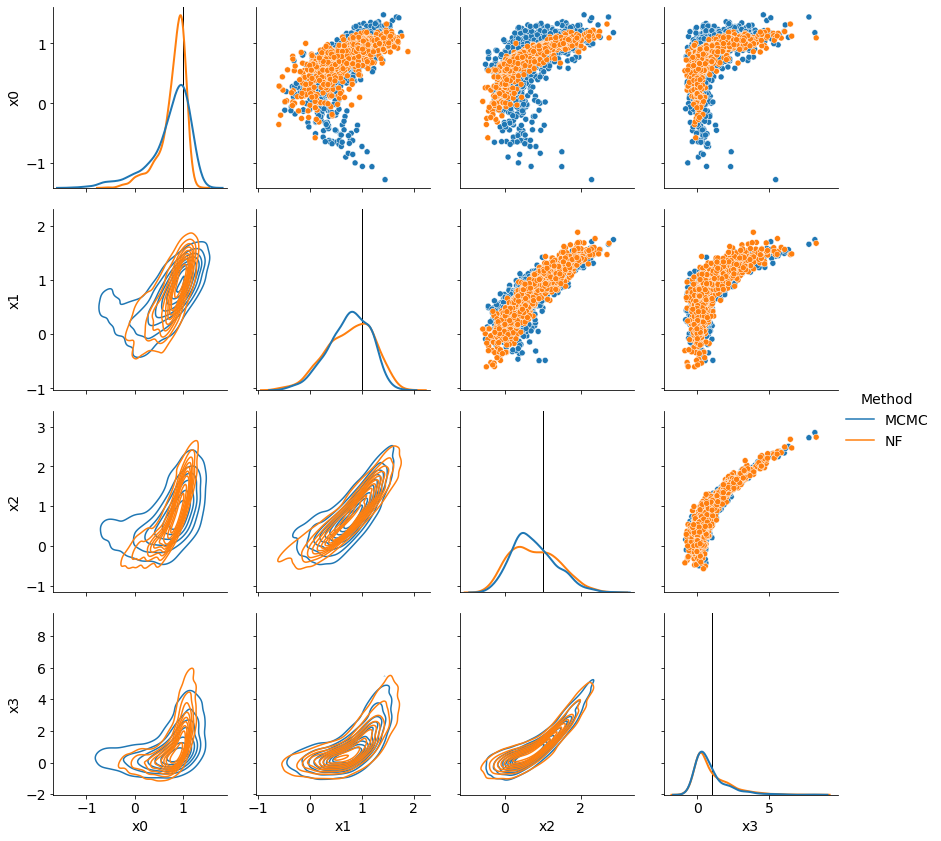

In [11]:
# Now compare MCMC with normalizing flows
sub_df = df.loc[df['Method'].isin(['MCMC', 'NF'])]

g = sns.PairGrid(sub_df, hue='Method', height=3)
g.map_diag(sns.kdeplot, lw=2, legend=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.add_legend()

for i in range(N_dim):
    ax = g.axes[i, i]
    ax.axvline(1, color='k', lw=1)

## Some takeaways

Clearly, the normalizing flow approximation does the best job in approximating the true Rosenbrock distribution (as compared to MCMC). What's interesting is the comparison between the Laplace approximation (optimization results) with the MVN variational distribution. As expected, the Laplace approximation is accurately aligned with the MAP point, but for highly skewed marginals, this can end up missing out on areas with a lot of probability mass. The MVN variational distribution, through the reverse KL-divergence loss, will try to shift the approximating MVN to cover more of this missing mass.